# Report the main study result on physicians' task performance with and without the assistance of AI prediction and explanation

In [23]:
from base_code import *
from scipy.stats import friedmanchisquare, wilcoxon
from statannot import add_stat_annotation

valid_data = pd.read_csv('../neurosurgeon35_data/neurosurgeon35.csv', index_col='Respondent ID')
xai25 = pd.read_csv('../computational_data/xai25.csv')
mriwise = pd.read_csv('../computational_data/mri_wise_acc.csv')
dr_wise_acc = pd.read_csv('../computational_data/dr_wise_acc.csv')
result_long = pd.read_csv('../computational_data/result_long.csv')

# 1. Physicians' task accuracy in the three conditions

In [25]:
# total valid response collected
print('total valid response collected:', (mriwise['DR_Num']+mriwise['DR+AI_Num']+mriwise['DR+XAI_Num']).sum())
print(mriwise['DR_Num'].sum(), mriwise['DR+AI_Num'].sum(),mriwise['DR+XAI_Num'].sum())

total valid response collected: 2279
761 759 759


In [10]:
dr_acc, ai_acc, xai_acc  =  dr_wise_acc['DR'], dr_wise_acc['DR+AI'], dr_wise_acc['DR+XAI']
acc_df = pd.DataFrame.from_dict({'dr_acc': dr_acc, 'ai_acc': ai_acc, 'xai_acc': xai_acc, 'id': dr_wise_acc['Respondent ID']}).set_index(keys='id')
acc_melt = pd.melt(acc_df.reset_index(), id_vars='id', value_vars=acc_df.columns)

print(rp.summary_cont(pd.Series(dr_acc)))
print(rp.summary_cont(pd.Series(ai_acc)))
print(rp.summary_cont(pd.Series(xai_acc)))

print('\n  \n')
# check ANOVA assumption 1: Univariate normality
print(pg.normality(dr_acc, method = 'shapiro')    )                                
print(pg.normality(ai_acc, method = 'shapiro')   )
print(pg.normality(xai_acc, method = 'shapiro')  )

# check Anova assuption 2: sphericity
# https://pingouin-stats.org/generated/pingouin.sphericity.html
print(pg.sphericity(data=acc_melt, dv='value', within='variable', subject='id', method = 'mauchly'))




  Variable     N    Mean      SD      SE  95% Conf.  Interval
0       DR  35.0  0.8249  0.0869  0.0147     0.7951    0.8548


  Variable     N   Mean      SD      SE  95% Conf.  Interval
0    DR+AI  35.0  0.877  0.0733  0.0124     0.8519    0.9022


  Variable     N    Mean      SD      SE  95% Conf.  Interval
0   DR+XAI  35.0  0.8852  0.0702  0.0119     0.8611    0.9093

  

           W      pval  normal
DR  0.908686  0.006826   False
              W      pval  normal
DR+AI  0.954511  0.155841    True
               W      pval  normal
DR+XAI  0.951066  0.122197    True
SpherResults(spher=True, W=812.3727470301952, chi2=-221.09865633563697, dof=2, pval=1.0)


(array([ 1.,  2.,  2.,  0.,  1., 10.,  6., 10.,  1.,  2.]),
 array([0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  ]),
 <BarContainer object of 10 artists>)

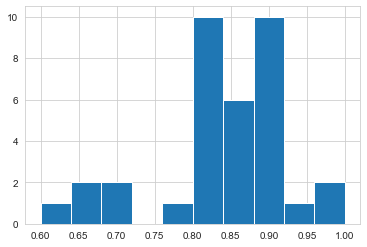

In [11]:
# visualize the dist since normality failed
plt.hist(dr_acc, bins =10)

(array([1., 0., 1., 5., 8., 0., 7., 6., 3., 4.]),
 array([0.68 , 0.712, 0.744, 0.776, 0.808, 0.84 , 0.872, 0.904, 0.936,
        0.968, 1.   ]),
 <BarContainer object of 10 artists>)

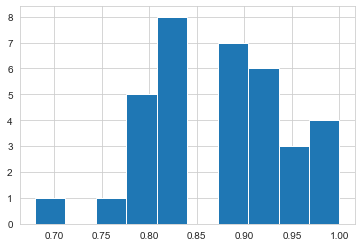

In [12]:
plt.hist(ai_acc, bins =10)

(array([1., 1., 4., 0., 6., 9., 0., 8., 1., 5.]),
 array([0.72 , 0.748, 0.776, 0.804, 0.832, 0.86 , 0.888, 0.916, 0.944,
        0.972, 1.   ]),
 <BarContainer object of 10 artists>)

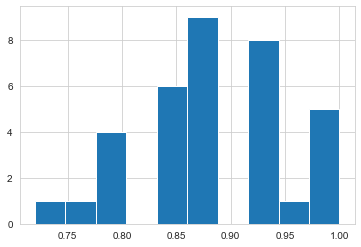

In [13]:
plt.hist(xai_acc, bins =10)

In [16]:
# report in manuscript Table 2
cdt = ['DR', 'DR+AI', 'DR+XAI']
for i, acc in enumerate([dr_acc, ai_acc, xai_acc]):
    adict = acc.describe().to_dict()
    print('\\ul{{{}}} & {:.0f} & ${:.2f}\pm{:.2f}$ & {:.2f} & {:.2f}& {:.2f}& {:.2f}& {:.2f} \\\\'.format(cdt[i], adict['count'],adict['mean']*100,adict['std']*100,
                                                           adict['min']*100, adict['25%']*100, adict['50%']*100, adict['75%']*100, adict['max']*100))


\ul{DR} & 35 & $82.49\pm8.69$ & 60.00 & 80.00& 84.00& 88.00& 100.00 \\
\ul{DR+AI} & 35 & $87.70\pm7.33$ & 68.00 & 84.00& 88.00& 92.00& 100.00 \\
\ul{DR+XAI} & 35 & $88.52\pm7.02$ & 72.00 & 84.00& 88.00& 92.00& 100.00 \\


In [19]:
# Friedman significance test
dr_acc, ai_acc, xai_acc  =  dr_wise_acc['DR'], dr_wise_acc['DR+AI'], dr_wise_acc['DR+XAI']
stat_acc, p_acc = friedmanchisquare(*[dr_acc, ai_acc, xai_acc])
print("Friedman test",stat_acc, p_acc)

# post-hoc test, reporting result
w, p1 = wilcoxon(np.array(ai_acc), np.array(dr_acc))#, alternative  = 'greater')
print(w, p1*3)
w, p2 = wilcoxon(np.array(xai_acc), np.array(dr_acc))#, alternative  = 'greater')
print(w, p2*3)
w, p3 = wilcoxon(np.array(xai_acc) ,np.array(ai_acc))# alternative  = 'greater')
print(w, p3*3)

Friedman test 23.534246575342415 7.7553836777596e-06
9.0 0.0015431450174520729
3.0 0.00040374051603298325
15.5 0.3454080284547485


In [44]:
# Report common language effect size
# https://pingouin-stats.org/generated/pingouin.compute_effsize.html
# https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00863/full
print("Common Language Effect Size", pg.compute_effsize(dr_wise_acc['DR+AI'].values, dr_wise_acc['DR'].values, paired = True, eftype='CLES'))
print("Common Language Effect Size", pg.compute_effsize(dr_wise_acc['DR+XAI'].values, dr_wise_acc['DR+AI'].values, paired = True, eftype='CLES'))
print("Common Language Effect Size", pg.compute_effsize(dr_wise_acc['DR+XAI'].values, dr_wise_acc['DR'].values, paired = True, eftype='CLES'))


Common Language Effect Size 0.6722448979591836
Common Language Effect Size 0.5355102040816326
Common Language Effect Size 0.710204081632653


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(scout_x, scout_y, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:644: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
dr_acc v.s. ai_acc: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.543e-03 stat=9.000e+00
Using zero_method  wilcox
ai_acc v.s. xai_acc: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.454e-01 stat=1.550e+01
Using zero_method  wilcox
dr_acc v.s. xai_acc: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.037e-04 stat=3.000e+00


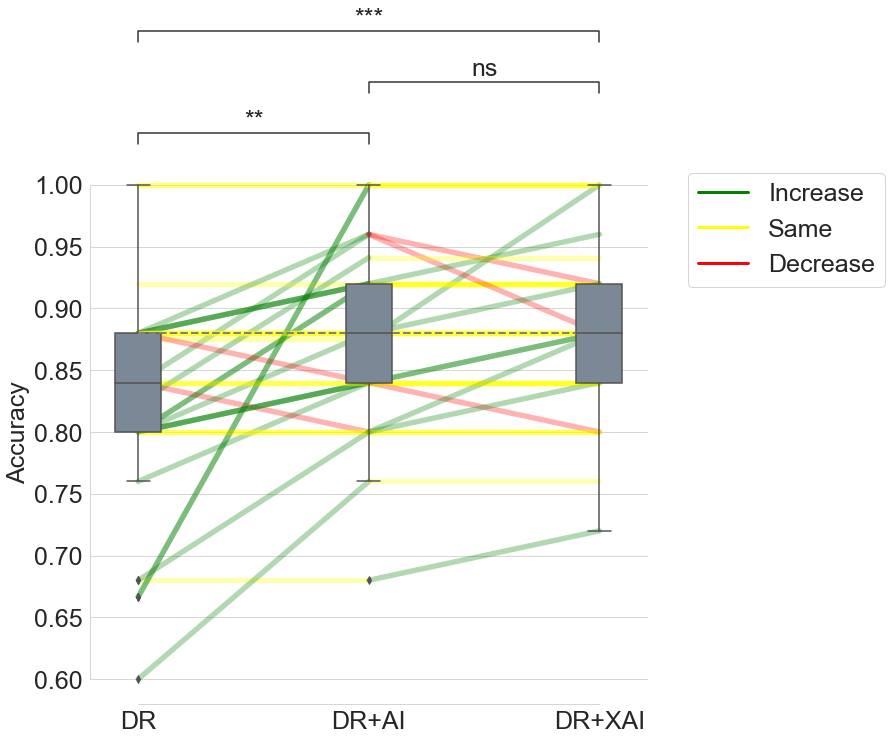

In [30]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 25})
# create long table for accuracy
acc_df = pd.DataFrame.from_dict({'dr_acc': dr_acc, 'ai_acc': ai_acc, 'xai_acc': xai_acc, 'id': valid_data.index}).set_index(keys='id')
acc_melt = pd.melt(acc_df.reset_index(), id_vars='id', value_vars=acc_df.columns)
ai_a = 0.88
order = ['dr_acc', 'ai_acc', 'xai_acc']
fig, ax = plt.subplots(figsize = (10,10))
ax = pg.plot_paired(ax = ax, data=acc_melt, dv='value', within='variable', subject='id', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 2, 'marker': '+'}, colors = ['green', 'yellow','red','orange'], boxplot_in_front=True, order = order)
ax.plot(['DR', 'DR+AI', 'DR+XAI'], [ai_a]*3, '--', color='gray', linewidth=2, markersize=12)

# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
p_values = [p1*3, p2*3, p3*3]
add_stat_annotation(ax, data=acc_melt, x='variable', y= 'value', order=order,
                    box_pairs=[("ai_acc", "dr_acc"), ("xai_acc", "dr_acc"), ("xai_acc", "ai_acc")],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'}, text_format='star', loc='outside', verbose=2)
ax.set_xticklabels(['DR', "DR+AI", 'DR+XAI'])

# custom legend of line colors
lw = 3
custom_lines = [Line2D([0], [0], color='green', lw=lw),
                Line2D([0], [0], color='yellow', lw=lw),
                Line2D([0], [0], color="red", lw=lw)]

ax.legend(custom_lines, ['Increase', 'Same', 'Decrease'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("")

plt.ylabel("Accuracy")
plt.savefig('../reporting/acc_new.pdf', bbox_inches='tight')


# 2. Test for whether complementary doctor-AI task performance was achieved

AI accuracy = 0.88

In [26]:
# complementary doctor-AI performance with AI prediction assistance
pg.ttest(ai_acc, 0.88, alternative = 'greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.239431,34,greater,0.593895,"[0.86, inf]",0.040471,0.373,0.030083


In [27]:
# complementary doctor-AI performance with XAI assistance
pg.ttest(xai_acc, 0.88, alternative = 'greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.436178,34,greater,0.332732,"[0.87, inf]",0.073728,0.396,0.111745


# 3. Fine-grained physicians task accuracy: resident+fellow vs. attending physicians

In [33]:
acc_vis = dr_wise_acc[['Respondent ID', 'DR', 'DR+AI', 'DR+XAI', 'Position']]
acc_vis_melt = pd.melt(acc_vis, id_vars=['Respondent ID', 'Position'], value_vars=['DR', 'DR+AI', 'DR+XAI'])
acc_vis_melt_attending = acc_vis_melt[acc_vis_melt['Position']=='Attending']
acc_vis_melt_resident = acc_vis_melt[acc_vis_melt['Position']!='Attending']

acc_vis_melt_attending.shape, acc_vis_melt_resident.shape

((36, 4), (69, 4))

In [34]:
# reporting in Supplemental S2
# descriptive statistics for attending or resident+fellow physicians
def acc_test_report(dr_wise_acc):
    cdt = ['DR', 'DR+AI', 'DR+XAI']
    for i, cd in enumerate(cdt):
        acc = dr_wise_acc[cd]
        adict = acc.describe().to_dict()
        print('\\textbf{{{}}} & {:.0f} & ${:.2f}\pm{:.2f}$ & {:.2f} & {:.2f}& {:.2f}& {:.2f}& {:.2f} \\\\'.format(cdt[i], adict['count'], adict['mean']*100,adict['std']*100,
                                                               adict['min']*100, adict['25%']*100, adict['50%']*100, adict['75%']*100, adict['max']*100))
acc_test_report(dr_wise_acc)

\textbf{DR} & 35 & $82.49\pm8.69$ & 60.00 & 80.00& 84.00& 88.00& 100.00 \\
\textbf{DR+AI} & 35 & $87.70\pm7.33$ & 68.00 & 84.00& 88.00& 92.00& 100.00 \\
\textbf{DR+XAI} & 35 & $88.52\pm7.02$ & 72.00 & 84.00& 88.00& 92.00& 100.00 \\


In [35]:
acc_test_report(dr_wise_acc[dr_wise_acc['Position']=='Attending'])

\textbf{DR} & 12 & $82.56\pm9.28$ & 66.67 & 79.00& 84.00& 88.00& 100.00 \\
\textbf{DR+AI} & 12 & $86.33\pm8.61$ & 68.00 & 84.00& 84.00& 89.00& 100.00 \\
\textbf{DR+XAI} & 12 & $87.67\pm7.90$ & 72.00 & 84.00& 88.00& 92.00& 100.00 \\


In [36]:
acc_test_report(dr_wise_acc[dr_wise_acc['Position']!='Attending'])

\textbf{DR} & 23 & $82.46\pm8.58$ & 60.00 & 80.00& 84.00& 88.00& 100.00 \\
\textbf{DR+AI} & 23 & $88.42\pm6.67$ & 76.00 & 84.00& 88.00& 92.00& 100.00 \\
\textbf{DR+XAI} & 23 & $88.96\pm6.66$ & 76.00 & 84.00& 88.00& 92.00& 100.00 \\


In [45]:
# significance test
def acc_test(dr_wise_acc, correction = False):
    dr_acc, ai_acc, xai_acc  =  dr_wise_acc['DR'], dr_wise_acc['DR+AI'], dr_wise_acc['DR+XAI']
    stat_acc, p_acc = friedmanchisquare(*[dr_acc, ai_acc, xai_acc])
    print("Friedman test",stat_acc, p_acc)

    # post-hoc test, reporting result
    zero_method_default = len(dr_acc) <= 20 and "pratt" or "wilcox"

    w, p1 = wilcoxon(np.array(ai_acc), np.array(dr_acc), zero_method=zero_method_default, correction=correction)#, alternative  = 'greater')
    print(w, p1*3, p1)
    w, p2 = wilcoxon(np.array(xai_acc), np.array(dr_acc), zero_method=zero_method_default, correction=correction)#, alternative  = 'greater')
    print(w, p2*3, p2)
    w, p3 = wilcoxon(np.array(xai_acc) ,np.array(ai_acc), zero_method=zero_method_default, correction=correction)# alternative  = 'greater')
    print(w, p3*3, p3)
    print(pg.wilcoxon(ai_acc, dr_acc))
    print(pg.wilcoxon(xai_acc, dr_acc))
    print(pg.wilcoxon(xai_acc, ai_acc))
    return p1*3, p2*3, p3*3

In [46]:
p_all = acc_test(dr_wise_acc)

Friedman test 23.534246575342415 7.7553836777596e-06
9.0 0.0015431450174520729 0.0005143816724840243
3.0 0.00040374051603298325 0.00013458017201099443
15.5 0.3454080284547485 0.11513600948491616
          W-val alternative     p-val       RBC      CLES
Wilcoxon  181.0     greater  0.000277  0.905263  0.672245
          W-val alternative     p-val       RBC      CLES
Wilcoxon  207.0     greater  0.000073  0.971429  0.710204
          W-val alternative     p-val       RBC     CLES
Wilcoxon   50.5     greater  0.062946  0.530303  0.53551


In [47]:
p_attending = acc_test(dr_wise_acc[dr_wise_acc['Position']=='Attending'])

Friedman test 8.272727272727252 0.01598085818548357
9.5 0.5089060304971729 0.16963534349905762
0.0 0.04746514447053864 0.01582171482351288
0.0 0.13870821433123237 0.04623607144374413
          W-val alternative   p-val       RBC      CLES
Wilcoxon   12.5     greater  0.1114  0.666667  0.607639
          W-val alternative     p-val  RBC      CLES
Wilcoxon   21.0     greater  0.017507  1.0  0.666667
          W-val alternative     p-val  RBC    CLES
Wilcoxon   10.0     greater  0.044487  1.0  0.5625


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  war

In [48]:
p_resident = acc_test(dr_wise_acc[dr_wise_acc['Position']!='Attending'])

Friedman test 16.980392156862752 0.00020547296734827426
2.0 0.0043760500380226695 0.0014586833460075565
2.0 0.004496523554926558 0.0014988411849755196
10.5 1.6383630353311955 0.5461210117770652
          W-val alternative     p-val       RBC      CLES
Wilcoxon  103.0     greater  0.000813  0.961905  0.702268
          W-val alternative     p-val       RBC      CLES
Wilcoxon  103.0     greater  0.000835  0.961905  0.731569
          W-val alternative     p-val   RBC      CLES
Wilcoxon   17.5     greater  0.302454  0.25  0.523629


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are 

/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(scout_x, scout_y, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:644: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
DR v.s. DR+AI: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.543e-03 stat=9.000e+00
Using zero_method  wilcox
DR+AI v.s. DR+XAI: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.454e-01 stat=1.550e+01
Using zero_method  wilcox
DR v.s. DR+XAI: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.037e-04 stat=3.000e+00


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(scout_x, scout_y, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:644: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
DR v.s. DR+AI: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.089e-01 stat=9.500e+00


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Using zero_method  pratt
DR+AI v.s. DR+XAI: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.387e-01 stat=0.000e+00
Using zero_method  pratt
DR v.s. DR+XAI: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.747e-02 stat=0.000e+00


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(scout_x, scout_y, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:644: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
DR v.s. DR+AI: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.376e-03 stat=2.000e+00


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Using zero_method  wilcox
DR+AI v.s. DR+XAI: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=1.050e+01


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Using zero_method  wilcox
DR v.s. DR+XAI: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.497e-03 stat=2.000e+00


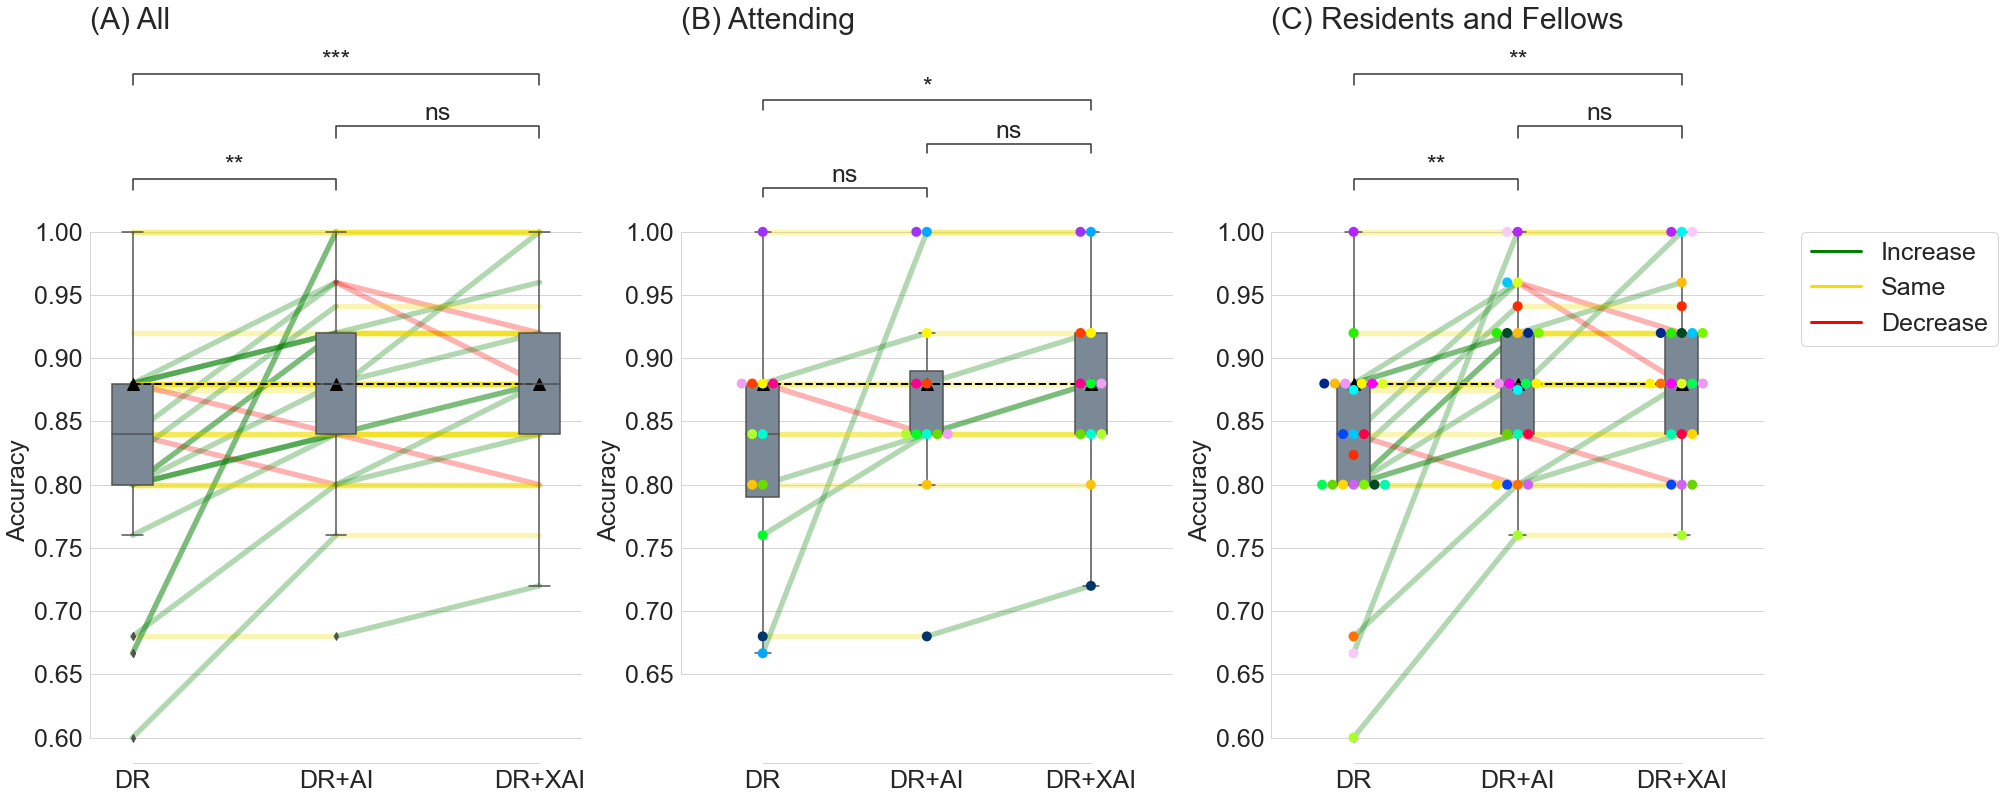

In [43]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 25})
# create long table for accuracy

yellow = '#F0DE00'
order = ['DR', 'DR+AI', 'DR+XAI']
title_pad =190
ai_acc = 0.88 #(13+54)/(13+54+7)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30,10))
# ax1
ax1 = pg.plot_paired(ax = axes[0], data=acc_vis_melt, dv='value', within='variable', subject='Respondent ID', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 2, 'marker': '+'}, colors = ['green', yellow,'red','orange'], boxplot_in_front=True, order = order)
ax1.plot(['DR', 'DR+AI', 'DR+XAI'], [ai_acc]*3, 'k^--', linewidth=2, markersize=12)
# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
add_stat_annotation(ax = axes[0], data=acc_vis_melt, x='variable', y= 'value', order=order,
                    box_pairs=[('DR', 'DR+AI'), ('DR', 'DR+XAI'), ('DR+AI', 'DR+XAI')],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'}, text_format='star', loc='outside', verbose=2)
ax1.set_xticklabels(['DR', "DR+AI", 'DR+XAI'])
ax1.set_xlabel("")
ax1.set_ylim([0.58, 1.01])
ax1.set_ylabel("Accuracy")
ax1.set_title("(A) All",  pad=title_pad, loc = 'left')

# ax2, attending physicians
ax2 = pg.plot_paired(ax = axes[1], data=acc_vis_melt_attending, dv='value', within='variable', subject='Respondent ID', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 2, 'marker': '+'}, colors = ['green', yellow,'red','orange'], boxplot_in_front=True, order = order)
ax2.plot(['DR', 'DR+AI', 'DR+XAI'], [ai_acc]*3, 'k^--', linewidth=2, markersize=12)
# plt.rcParams.update({'font.size': 30})
sns.swarmplot(ax = axes[1], data = acc_vis_melt_attending, x = 'variable', y = 'value', hue = 'Respondent ID', palette = "gist_ncar", size=10)
# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
add_stat_annotation(ax = axes[1], data=acc_vis_melt_attending, x='variable', y= 'value', order=order,
                    box_pairs=[('DR', 'DR+AI'), ('DR', 'DR+XAI'), ('DR+AI', 'DR+XAI')],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'}, text_format='star', loc='outside', verbose=2)
ax2.set_xticklabels(['DR', "DR+AI", 'DR+XAI'])
ax2.set_xlabel("")
ax2.set_ylim([0.58, 1.01])
ax2.set_ylabel("Accuracy")
ax2.get_legend().remove()
ax2.set_title("(B) Attending",  pad=title_pad, loc = 'left')


ax3 = pg.plot_paired(ax = axes[2], data=acc_vis_melt_resident, dv='value', within='variable', subject='Respondent ID', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 2, 'marker': '+'}, colors = ['green', yellow,'red','orange'], boxplot_in_front=True, order = order)
ax3.plot(['DR', 'DR+AI', 'DR+XAI'], [ai_acc]*3, 'k^--', linewidth=2, markersize=12)
sns.swarmplot(ax = axes[2], data = acc_vis_melt_resident, x = 'variable', y = 'value', hue = 'Respondent ID', palette = "gist_ncar", size=10)
# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
add_stat_annotation(ax = axes[2], data=acc_vis_melt_resident, x='variable', y= 'value', order=order,
                    box_pairs=[('DR', 'DR+AI'), ('DR', 'DR+XAI'), ('DR+AI', 'DR+XAI')],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'}, text_format='star', loc='outside', verbose=2)
ax3.set_xticklabels(['DR', "DR+AI", 'DR+XAI'])
ax3.set_xlabel("")
ax3.set_ylim([0.58, 1.01])
ax3.set_ylabel("Accuracy")
ax3.set_title("(C) Residents and Fellows",  pad=title_pad, loc = 'left')

# custom legend of line colors
lw = 3
custom_lines = [Line2D([0], [0], color="green", lw=lw),
                Line2D([0], [0], color= yellow, lw=lw),
                Line2D([0], [0], color='red', lw=lw)]

ax3.legend(custom_lines, ['Increase', 'Same', 'Decrease'], bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.legend() # uncomment to shown id legend

# plt.savefig('../reporting/acc_finegrained.pdf', bbox_inches='tight')
# ax.set_title("Accuracy w/o and w/ AI/XAI assistance")